In [2]:
import vplanet_inference as vpi
import numpy as np
import os
import time
from functools import partial
import multiprocessing as mp
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=35)
rc('ytick', labelsize=35)

In [3]:
def load_sims(file):    
    
    sims = np.load(file)
    theta = sims['theta'].T[0]
    y = sims['y']

    resort = np.argsort(theta)
    theta = theta[resort]
    y = y[resort]
    
    return theta, y

In [4]:
trng = {50: [-1.1,1.2,1.2],
        500: [-1.2,0.5,0.5],
        5000: [-1.3,-0.6,-0.6]}

qrng = {50: [5.2,5.2,3.8],
        500: [7.3,7.3,4.6],
        5000: [8.1,8.1,5.8]}

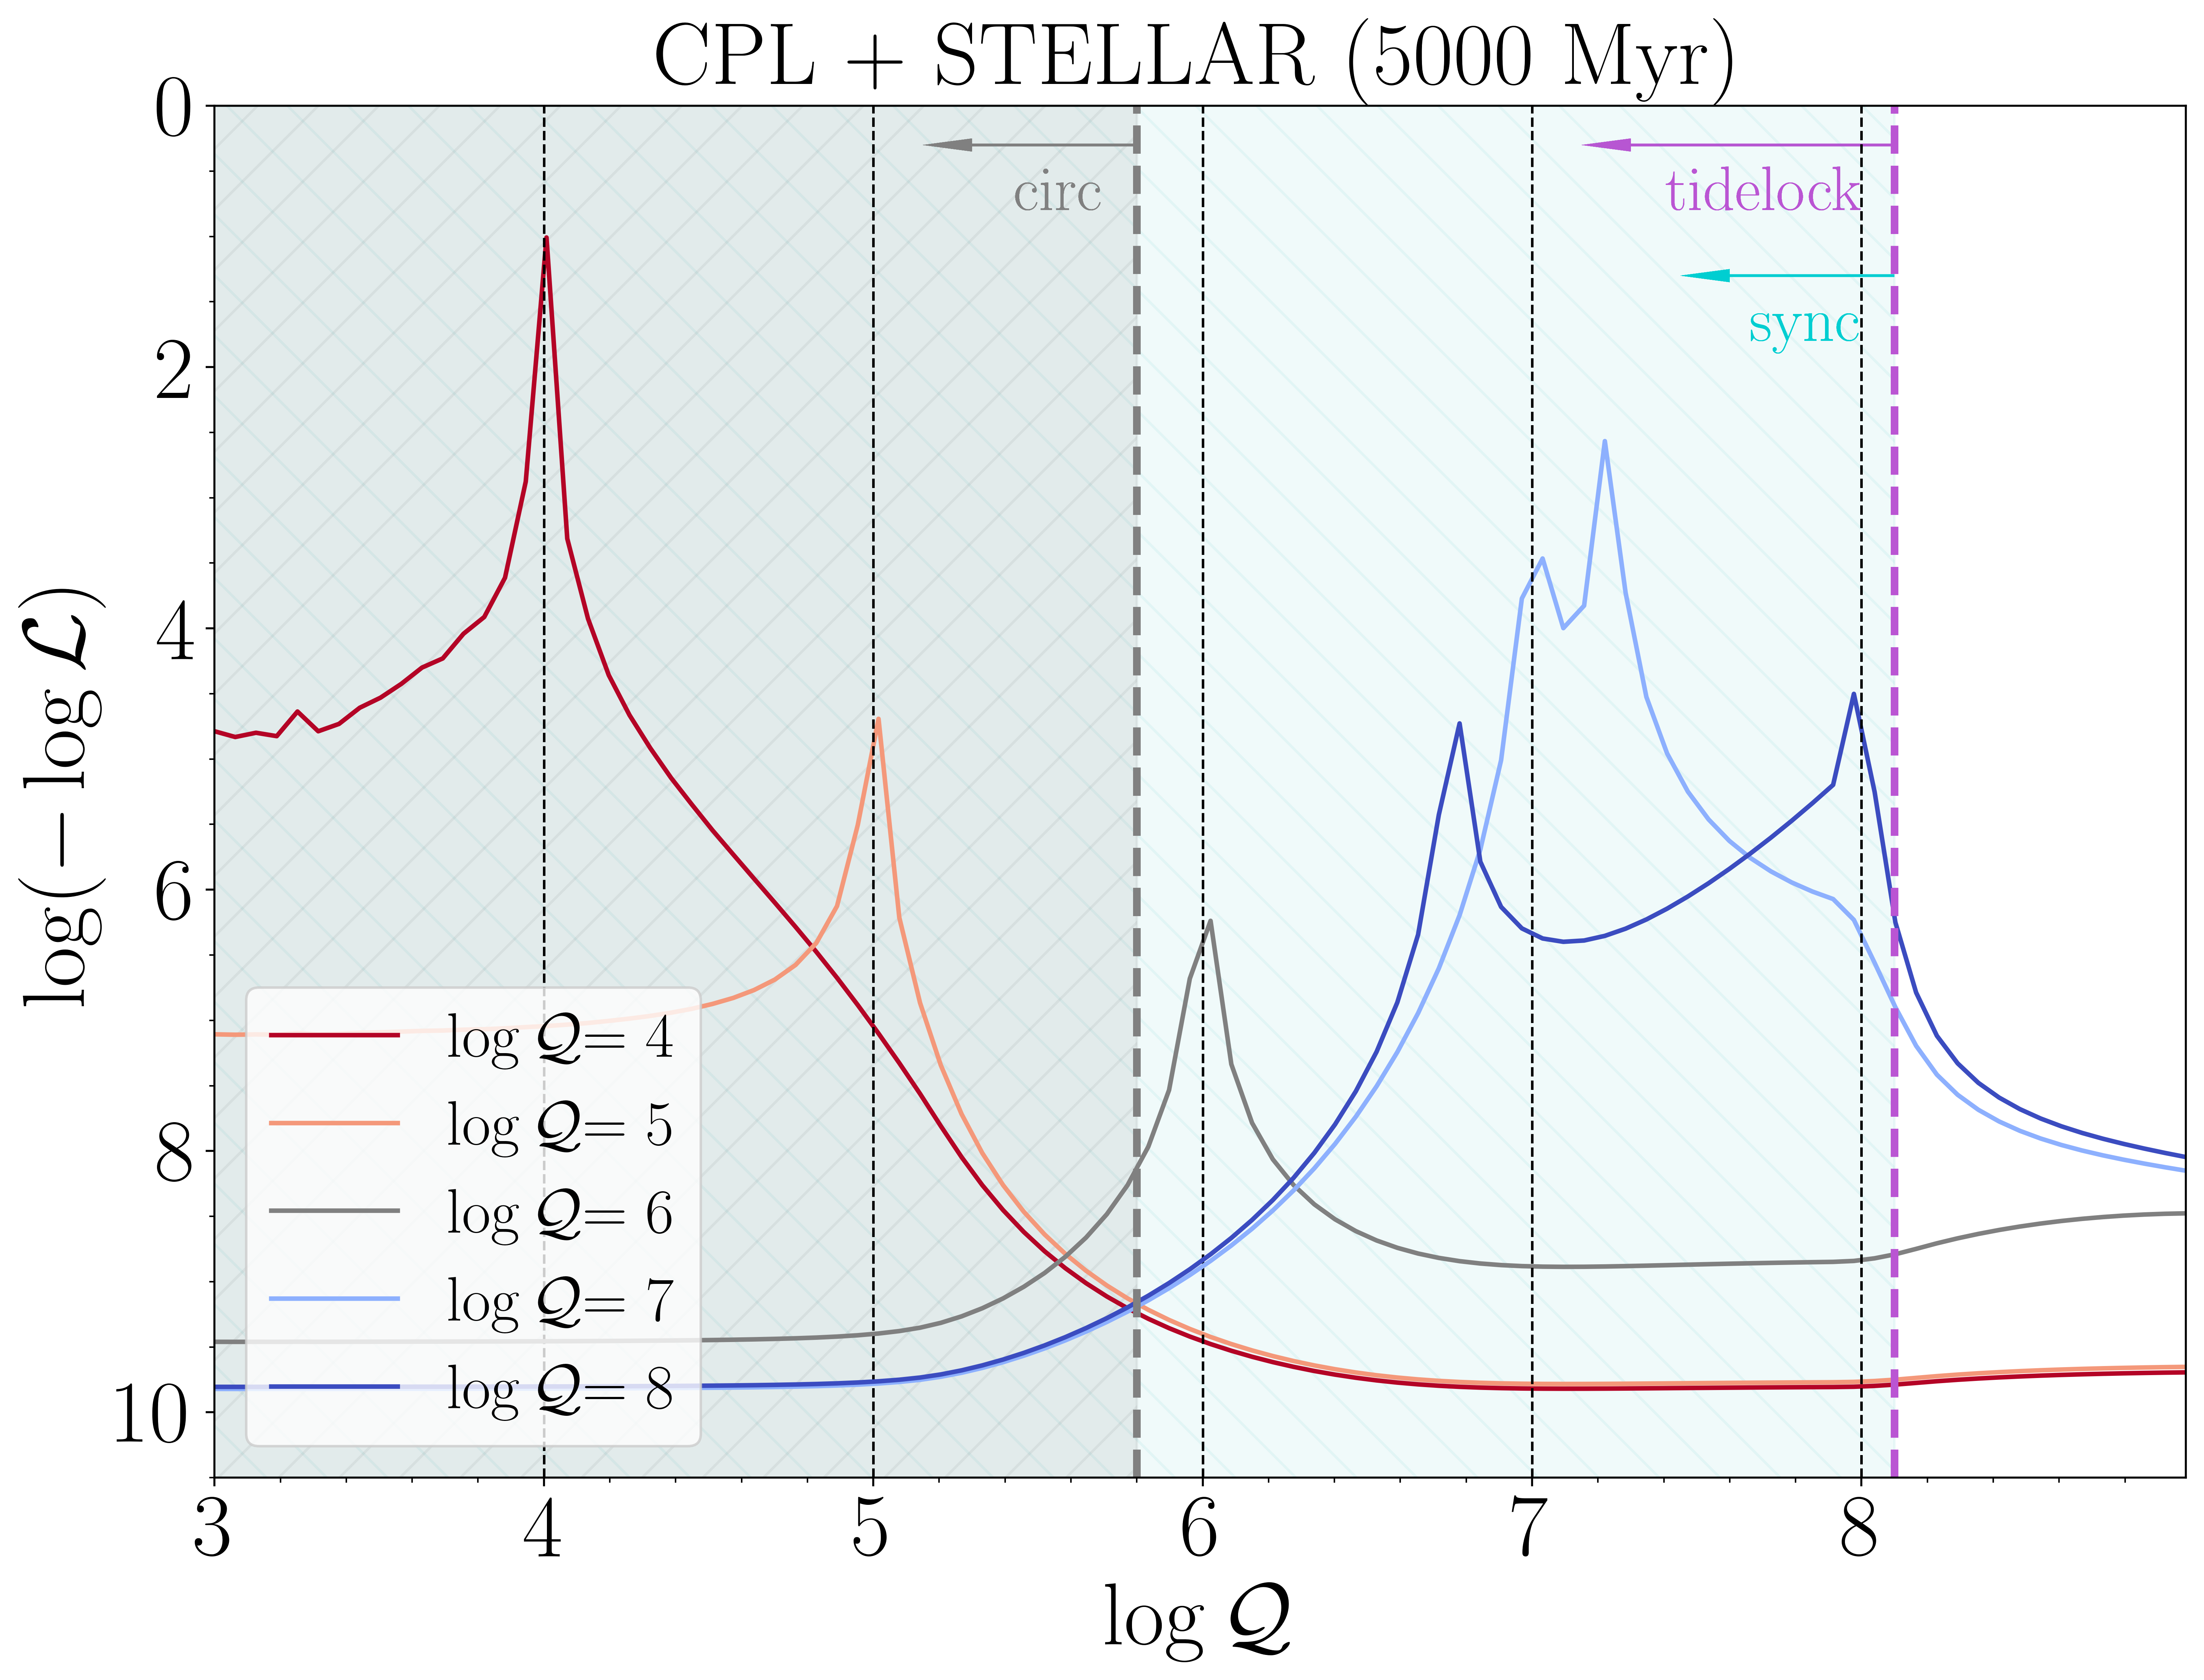

In [7]:
age_true = 5000
tide_model="cpl"

if tide_model == "ctl":
    true_tides = [-3, -2, -1, 0, 1]
elif tide_model == "cpl":
    true_tides = [4, 5, 6, 7, 8]
respath=f"../analysis/results_likelihood_1d/{tide_model}_stellar_eqtide/results/full_likelihood"
fs=35

cmap = mpl.cm.coolwarm
c = np.arange(0, len(true_tides))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cmap.set_array([])
colors = [cmap.to_rgba(ii) for ii in range(len(true_tides))]
colors[2] = "grey"

if tide_model == "ctl":
    tide_label = r"$\log\tau$ [s]"
elif tide_model == "cpl":
    tide_label = r"$\log\mathcal{Q}$"
    colors = colors[::-1]
        
plt.figure(figsize=[14,10], dpi=500)
yarr = []

results = ["tide_"+str(tv).replace("-", "n") for tv in true_tides]

for ii, res in enumerate(results):
    theta, y = load_sims(f"{respath}/1param_{tide_model}_{age_true}_myr/{res}/tide_likelihood_sample.npz")
    yarr.append(np.log10(-y))
    
    pl_label = tide_label + r"$=%s$"%(true_tides[ii])
    plt.plot(theta, np.log10(-y), linewidth=1.8, color=colors[ii], label=pl_label)
    plt.axvline(x=true_tides[ii], linestyle='--', color='k', linewidth=1)
    
    tcolor = "mediumorchid"
    scolor = "darkturquoise"
    ccolor = "grey"
    arrow_height = .3
    if tide_model == "ctl":
        
        # tidelock
        plt.axvline(trng[age_true][0], linestyle="--", color=tcolor, linewidth=3)
        # plt.axvspan(trng[age_true][0], 2, color=tcolor, alpha=0.01)
        plt.arrow(trng[age_true][0], arrow_height, .8, 0, width=0.02, head_width=0.1, ec="none", fc=tcolor)
        plt.text(trng[age_true][0]+.1, arrow_height+.5, 'tidelock', color=tcolor, fontsize=fs-10)
        
        # sync
        plt.axvspan(trng[age_true][1], 2, color=scolor, hatch="\\", alpha=0.01)
        plt.arrow(trng[age_true][1], arrow_height, .5, 0, width=0.02, head_width=0.1, ec="none", fc=scolor)
        plt.text(trng[age_true][1]+.1, arrow_height+.5, 'sync', color=scolor, fontsize=fs-10)
        
        # circ
        plt.axvline(trng[age_true][2], linestyle="--", color=ccolor, linewidth=3)
        plt.axvspan(trng[age_true][2], 2, color=ccolor, hatch="/", alpha=0.01)
        plt.arrow(trng[age_true][1], arrow_height+1, .5, 0, width=0.02, head_width=0.1, ec="none", fc=ccolor)
        plt.text(trng[age_true][1]+.1, arrow_height+1.5, 'circ', color=ccolor, fontsize=fs-10)
        
        plt.legend(loc='upper left', fontsize=fs-10)
        
    elif tide_model == "cpl":
        
        # tidelock
        plt.axvline(qrng[age_true][0], linestyle="--", color=tcolor, linewidth=3)
        # plt.axvspan(qrng[age_true][0], 2, color=scolor, alpha=0.01)
        plt.arrow(qrng[age_true][0], arrow_height, -.8, 0, width=0.02, head_width=0.1, ec="none", fc=tcolor)
        plt.text(qrng[age_true][0]-.1, arrow_height+.5, 'tidelock', ha="right", color=tcolor, fontsize=fs-10)
        
        # sync
        plt.axvspan(qrng[age_true][1], 2, color=scolor, hatch="\\", alpha=0.01)
        plt.arrow(qrng[age_true][1], arrow_height+1, -.5, 0, width=0.02, head_width=0.1, ec="none", fc=scolor)
        plt.text(qrng[age_true][1]-.1, arrow_height+1.5, 'sync', ha="right", color=scolor, fontsize=fs-10)
        
        # circ
        plt.axvline(qrng[age_true][2], linestyle="--", color=ccolor, linewidth=3)
        plt.axvspan(qrng[age_true][2], 2, color=ccolor, hatch="/", alpha=0.02)
        plt.arrow(qrng[age_true][2], arrow_height, -.5, 0, width=0.02, head_width=0.1, ec="none", fc=ccolor)
        plt.text(qrng[age_true][2]-.1, arrow_height+.5, 'circ', ha="right", color=ccolor, fontsize=fs-10)
        
        plt.legend(loc='lower left', fontsize=fs-10)
        # plt.legend(loc='lower right', fontsize=fs-10)

plt.title(f"{tide_model.upper()} + STELLAR ({age_true} Myr)", fontsize=fs)
plt.xlabel(tide_label, fontsize=fs)
plt.ylabel(r"$\log(-\log\mathcal{L})$", fontsize=fs)
plt.xlim(min(theta), max(theta))
plt.ylim(10.5, 0)
yf = np.array(yarr).flatten()
plt.minorticks_on()
plt.savefig(f"../figures/{tide_model}_vary_tide_likelihood_{age_true}_myr.png", bbox_inches="tight")
plt.show()